# Reducing NIRSpec MOS data using the JWST Calibration Pipeline

This is a very direct workflow of the pipeline. All changes to the pipleine steps are handled through the `config_file's. 

Important to check what steps can be multiprocessed etc. 

The pipeline stages are documented here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html

In [8]:
import asdf
import os
import glob
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

#### Change the path below to a directory on your machine. All calibration files will be downloaded here. 
os.environ['CRDS_PATH'] = os.path.expanduser('/lustre/JDAP/jdap_data/crds_cache') 

output_dir = './'

# MSA meta data file

Key information about the MOS observations are stored in this file. 
Read about the file here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/msa_metadata.html


Because we are only interested in one object (for now in order to save time) we will edit the file so the pipleine will only process that object.

If you only have one object in a list and the trace only falls in one detector, for Stage 2 and 3 you need to only use the detector where the object is included. If you have the other detector the peipline will produce an error.

First copy the * .fits files you downloaded from the previous notebook. Then add a suffix "_orginal" to the msa*.fits file. This is so that the original file is not amended when you make changes. 

In [2]:
from astropy.io import fits
from astropy.table import Table

In [3]:
meta_data_file_name = 'jw02565007001_01_msa_original.fits' #"_original" is a suffix that is not recognized by the pipeline.

In [4]:
gal_id =  20115 ## name the source we are interested in

In [5]:

meta_file = fits.open(meta_data_file_name)


msa_metadata_source_info = Table.read(meta_data_file_name, hdu=3).to_pandas()
msa_metadata_slit_info = Table.read(meta_data_file_name, hdu=2).to_pandas()

msa_metadata_source_info = msa_metadata_source_info[msa_metadata_source_info['source_id']==gal_id]

msa_metadata_source_info['stellarity'] = 1.0


meta_file['SOURCE_INFO'] =fits.BinTableHDU(Table.from_pandas(msa_metadata_source_info), name='SOURCE_INFO')

msa_metadata_slit_info = msa_metadata_slit_info.query('slitlet_id==' + str(msa_metadata_slit_info.query('source_id=='+str(gal_id)).slitlet_id.values[0]) + '| slitlet_id==' + str(msa_metadata_slit_info.query('source_id=='+str(gal_id)).slitlet_id.values[1]) +  ' | slitlet_id==' + str(msa_metadata_slit_info.query('source_id=='+str(gal_id)).slitlet_id.values[2]))


meta_file['SHUTTER_INFO'] =fits.BinTableHDU(Table.from_pandas(msa_metadata_slit_info), name='SHUTTER_INFO')

print("Source info", meta_file['SOURCE_INFO'].data)
print("Shutter info", meta_file['SHUTTER_INFO'].data)

meta_data_file_name_new = meta_data_file_name.replace('msa_original', 'msa')

meta_file.writeto(meta_data_file_name_new, overwrite=True)

Source info [(2565, 20115, '2565_20115', '20115', 150.06146711, 2.37868632, 'None', 1.)]
Shutter info [(30, 1, 2, 138, 108,     0, 'Y', 'OPEN',   nan,   nan, 1, 'N')
 (30, 1, 2, 138, 108,     0, 'Y', 'OPEN',   nan,   nan, 3, 'N')
 (30, 1, 2, 138, 108, 20115, 'N', 'OPEN', 0.73 , 0.506, 2, 'Y')
 (30, 1, 2, 138, 109,     0, 'Y', 'OPEN',   nan,   nan, 1, 'N')
 (30, 1, 2, 138, 109,     0, 'Y', 'OPEN',   nan,   nan, 2, 'N')
 (30, 1, 2, 138, 109,     0, 'Y', 'OPEN',   nan,   nan, 3, 'N')
 (30, 1, 2, 138, 110,     0, 'Y', 'OPEN',   nan,   nan, 2, 'N')
 (30, 1, 2, 138, 110,     0, 'Y', 'OPEN',   nan,   nan, 3, 'N')
 (30, 1, 2, 138, 110, 20115, 'N', 'OPEN', 0.713, 0.529, 1, 'Y')
 (30, 1, 2, 138, 111,     0, 'Y', 'OPEN',   nan,   nan, 1, 'N')
 (30, 1, 2, 138, 111,     0, 'Y', 'OPEN',   nan,   nan, 2, 'N')
 (30, 1, 2, 138, 111,     0, 'Y', 'OPEN',   nan,   nan, 3, 'N')
 (30, 1, 2, 138, 112,     0, 'Y', 'OPEN',   nan,   nan, 1, 'N')
 (30, 1, 2, 138, 112,     0, 'Y', 'OPEN',   nan,   nan, 2, 'N')
 (

If you want to run the pipeline for all objects just use the file directly downloaded in the previous step. 

# STAGE 1

Works in detector space. We will use stage 1 data products from MAST and skip this step for now but the overall process is similar. 


We will skip running Stage 1 of the pipeline for the workshop because it takes a long time. 

**Exercise**
- Because we are skipping the Stage 1 of the pipleine, go to https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html to make sure you understand what steps are performed. Now how common Stage 1 is between NIRSpec and other instruments.
- Open one of the *.uncal files in ds9 or QfitsView and see if you can understand how the data is stored.

You will need to download the *uncal.fits files from the previous notebook.

In [ ]:
from jwst.pipeline.calwebb_detector1 import Detector1Pipeline

det1 = Detector1Pipeline()

det_param_reffile = os.path.join(output_dir, 'manual_calwebb_det1.asdf')

Export the asdf file and manually edit as needed

In [ ]:
if os.path.exists(det_param_reffile):
    print(det_param_reffile, ' file is already in directory. It will not be overwritten')
else: 
    det1.export_config(det_param_reffile)

Some steps can also be manually changed within the python objects. However, lets stick to editing the .asdf file directly, so there is no confusion about what setting has the highest priority. 

Make sure to change the "save_results: true" in  "Detector1Pipeline" parameters. 

Get all uncal.fits files. We will feed them into the pipeline to be reduced one at a time. 

In [ ]:
level0_data_files = glob.glob(output_dir+'*uncal.fits')
level0_data_files.sort()
level0_data_files

print('files to execute', level0_data_files)

In [ ]:
for fits_image in level0_data_files:
    det1.call(fits_image, config_file=det_param_reffile, output_dir=output_dir)

# STAGE 2

Now you already have the *rate.fits files. Open all of them and check the data and err images to see if you detect anything abnormal. 
Check NIRSpec known issues https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues#gsc.tab=0 and also NIRSpec MOS known issues to see if you spot anything https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-mos-known-issues#gsc.tab=0 . 


In [6]:
from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

In [9]:
spec2 = Spec2Pipeline()
spec2_param_reffile = os.path.join(output_dir, 'manual_calwebb_spec2.asdf')

2024-06-28 09:47:23,655 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-06-28 09:47:23,657 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-06-28 09:47:23,660 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.
2024-06-28 09:47:23,662 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-06-28 09:47:23,664 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-06-28 09:47:23,665 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-06-28 09:47:23,667 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-06-28 09:47:23,668 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2024-06-28 09:47:23,672 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2024-06-28 09:47:23,673 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INF

In [10]:
if os.path.exists(spec2_param_reffile):
    print(spec2_param_reffile, ' file is already in directory. It will not be overwritten')
else: 
    spec2.export_config(spec2_param_reffile)


./manual_calwebb_spec2.asdf  file is already in directory. It will not be overwritten


We now have an association file. This will determine the node patterns etc. 
Check more information here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/overview.html

Then look at the .asn file for this stage to make sure all is good and is as expected. 

If everything is good we are ready for the data to be reduced

Make sure to ask the spec2 to save the results: 
"save_results: true"

In [11]:
%%time

spec2_asn_file = 'manual_calwebb2_asn.json'
result = spec2.call(spec2_asn_file, config_file=spec2_param_reffile)

2024-06-28 09:47:51,308 - CRDS - INFO -  Fetching  /Users/wnanayakkara/Dropbox/JADC/pipelines/crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 189 files) (0 / 703.5 K bytes)
2024-06-28 09:47:52,215 - CRDS - INFO -  Fetching  /Users/wnanayakkara/Dropbox/JADC/pipelines/crds_cache/mappings/jwst/jwst_system_calver_0037.rmap    4.7 K bytes  (2 / 189 files) (694 / 703.5 K bytes)
2024-06-28 09:47:53,119 - CRDS - INFO -  Fetching  /Users/wnanayakkara/Dropbox/JADC/pipelines/crds_cache/mappings/jwst/jwst_system_0036.imap      385 bytes  (3 / 189 files) (5.4 K / 703.5 K bytes)
2024-06-28 09:47:54,020 - CRDS - INFO -  Fetching  /Users/wnanayakkara/Dropbox/JADC/pipelines/crds_cache/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 189 files) (5.8 K / 703.5 K bytes)
2024-06-28 09:47:54,891 - CRDS - INFO -  Fetching  /Users/wnanayakkara/Dropbox/JADC/pipelines/crds_cache/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 189 files) (7.

CPU times: user 4min 3s, sys: 32.5 s, total: 4min 35s
Wall time: 1h 12min 33s


# STAGE 3

**Exercise:**
Go to https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html and read what steps will be run by the pipleine in Stage 2. 

In [12]:
from jwst.pipeline.calwebb_spec3 import Spec3Pipeline

In [13]:
spec3 = Spec3Pipeline()

spec3_param_reffile = os.path.join(output_dir, 'manual_calwebb_spec3.asdf')

2024-06-28 11:00:17,673 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2024-06-28 11:00:17,675 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2024-06-28 11:00:17,678 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2024-06-28 11:00:17,679 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2024-06-28 11:00:17,682 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2024-06-28 11:00:17,684 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.
2024-06-28 11:00:17,686 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2024-06-28 11:00:17,688 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2024-06-28 11:00:17,691 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2024-06-28 11:00:17,693 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep in

In [14]:
if os.path.exists(spec3_param_reffile):
    print(spec3_param_reffile, ' file is already in directory. It will not be overwritten')
else: 
    spec3.export_config(spec3_param_reffile)

./manual_calwebb_spec3.asdf  file is already in directory. It will not be overwritten


Now change params in asdf file so results are saved and remove the outlier detection steps, master background substraction steps, and the 1d extraction (we will perform the latter seperately in a more optimal way).

In [15]:
#spec3.outlier_detection.skip = True ### the .asdf file seems to have higher priority now. so changes need to happen there

There is another association file for this step! Check the differences out. 

In [17]:
%%time

result = spec3.call(output_dir+ 'manual_calwebb3_asn.json' , save_results=True, 
                  config_file=spec3_param_reffile, output_dir=output_dir)

2024-06-28 11:02:38,906 - CRDS - ERROR -  Error determining best reference for 'pars-outlierdetectionstep'  =    parameter='META.EXPOSURE.TYPE [EXP_TYPE]' value='NRS_MSASPEC' is not in ['NRS_IFU']
2024-06-28 11:02:38,921 - CRDS - ERROR -  Error determining best reference for 'pars-spectralleakstep'  =   Unknown reference type 'pars-spectralleakstep'
2024-06-28 11:02:38,951 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2024-06-28 11:02:38,952 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2024-06-28 11:02:38,953 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2024-06-28 11:02:38,955 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2024-06-28 11:02:38,956 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2024-06-28 11:02:38,958 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.
2024-06-28 11:02:38,960 - s

CPU times: user 24.2 s, sys: 750 ms, total: 24.9 s
Wall time: 8.96 s


if you get: 
"ValidationError: Extra value 'scale_detection' in steps/outlier_detection"

delete the:
"    scale_detection: false"
line in the spec3.asdf file. 

After this step the calibration pipleine is complete. You should have 2D and 1D (if you didn't skip that step) science products. 

The current calibration pipeline doesn't perfrom an optimal 1D extraction. So we will do that later on outside of the ST pipeline. 

# Check 2D pipleine outputs

You can use a software like QFitsView https://www.mpe.mpg.de/~ott/QFitsView/ and/or DS9 https://sites.google.com/cfa.harvard.edu/saoimageds9 to view the data products. 

They can also be opened up in python. I personally prefer to use a fits viewer instead.
Alwways check Stage 1,2,3 results to make sure no issues. We will focus on Stage 2 and 3 here.

## STAGE 2 products

In [18]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval


In [19]:
cal_files = glob.glob('*cal.fits')
cal_files

['jw02565-o007_s000020115_nirspec_clear-prism_cal.fits',
 'jw02565007001_03101_00004_nrs2_cal.fits',
 'jw02565007001_03101_00003_nrs2_cal.fits',
 'jw02565007001_03101_00002_nrs2_cal.fits']

In [20]:
## check what is included
fits.open(cal_files[0]).info()

Filename: jw02565-o007_s000020115_nirspec_clear-prism_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     364   ()      
  1  SCI           1 ImageHDU        98   (419, 38)   float32   
  2  DQ            1 ImageHDU        11   (419, 38)   int32 (rescales to uint32)   
  3  ERR           1 ImageHDU        10   (419, 38)   float32   
  4  WAVELENGTH    1 ImageHDU         9   (419, 38)   float32   
  5  BARSHADOW     1 ImageHDU         9   (419, 38)   float32   
  6  VAR_POISSON    1 ImageHDU         9   (419, 38)   float32   
  7  VAR_RNOISE    1 ImageHDU         9   (419, 38)   float32   
  8  VAR_FLAT      1 ImageHDU         9   (419, 38)   float32   
  9  PATHLOSS_PS    1 ImageHDU         9   (419, 38)   float32   
 10  PATHLOSS_UN    1 ImageHDU         9   (419, 38)   float32   
 11  SCI           2 ImageHDU        72   (419, 38)   float32   
 12  DQ            2 ImageHDU        11   (419, 38)   int32 (rescales to uint32)   
 13

In [21]:
### information about the reductions can be found in the headers
fits.open(cal_files[0])[0].header ### use 0, 1, 2 like index or names like 'SCI'



SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-06-28T04:02:41.323' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'jw02565-o007_s000020115_nirspec_clear-prism_cal.fits' / Name of the f
SDP_VER = '2023_4a '           / Data processing (DP) Software Version          
PRD_VER = 'PRDOPSSOC-065'      / S&OC Project Reference Database (PRD) Version  
OSS_VER = '8.5     '           / Observatory Scheduling Software (OSS) Version  
GSC_VER = 'GSC30   '        


Figure out the units of the flux measurements in the cal file

### plot the image

Noting the +ve trace and the 2 negative traces due to the 
A-(B+C)/2 like nod pattern

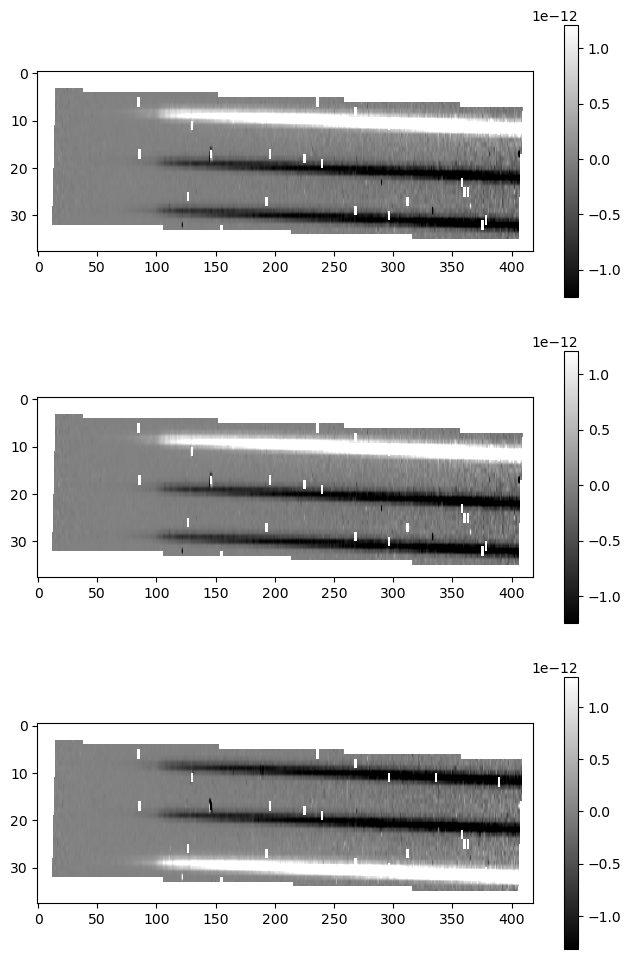

In [22]:
fig, axs = plt.subplots(nrows=3, figsize=(8,12))

axs.flatten()

for i in range(3):

    sci_image = fits.open(cal_files[i])['SCI'].data
    ### make in too like zscale in ds9 (can wipe out features so be careful)
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(sci_image)
    
    
    cax = axs[i].imshow(sci_image, aspect=4, vmin=vmin, vmax=vmax, cmap='gray')
    
    fig.colorbar(cax, ax=axs[i], orientation='vertical', label='') ## add the units to the axis label



## STAGE 3 products

Go to https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html and read what steps will be run by the pipleine in Stage 3.

In [23]:
import glob
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval


In [24]:
s2d_files = glob.glob('*s2d.fits')
s2d_files.sort(reverse=True) ### reverse the order so that we look at the intermediate s2d files first
s2d_files

['jw02565007001_03101_00004_nrs2_s2d.fits',
 'jw02565007001_03101_00003_nrs2_s2d.fits',
 'jw02565007001_03101_00002_nrs2_s2d.fits',
 'jw02565-o007_s000020115_nirspec_clear-prism_s2d.fits']

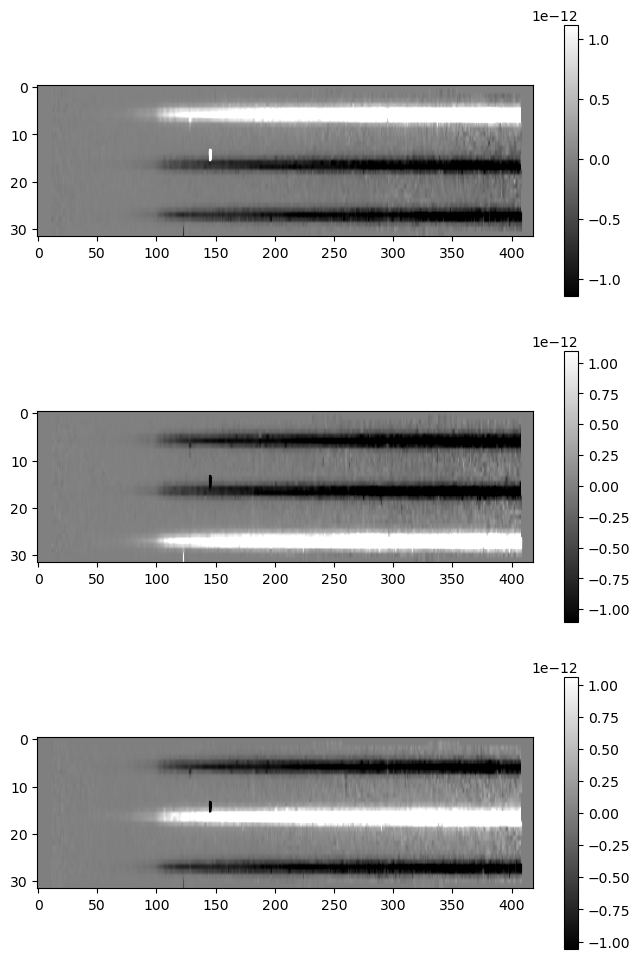

In [25]:
fig, axs = plt.subplots(nrows=3, figsize=(8,12))

axs.flatten()

for i in range(3):

    sci_image = fits.open(s2d_files[i])['SCI'].data
    ### make in too like zscale in ds9 (can wipe out features so be careful)
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(sci_image)
    
    
    cax = axs[i].imshow(sci_image, aspect=4, vmin=vmin, vmax=vmax, cmap='gray')
    
    fig.colorbar(cax, ax=axs[i], orientation='vertical', label='') ## add the units to the axis label



#### Look at the final 2D combine frame

In [28]:
final_2d_combine_name = 'jw02565-o007_s000020115_nirspec_clear-prism_s2d.fits'
fits.open(final_2d_combine_name).info()

Filename: jw02565-o007_s000020115_nirspec_clear-prism_s2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     374   ()      
  1  SCI           1 ImageHDU        89   (419, 52)   float32   
  2  ERR           1 ImageHDU        10   (419, 52)   float32   
  3  WAVELENGTH    1 ImageHDU         9   (419, 52)   float32   
  4  WHT           1 ImageHDU         9   (419, 52)   float32   
  5  CON           1 ImageHDU        10   (419, 52, 1)   int32   
  6  VAR_POISSON    1 ImageHDU         9   (419, 52)   float32   
  7  VAR_RNOISE    1 ImageHDU         9   (419, 52)   float32   
  8  VAR_FLAT      1 ImageHDU         9   (419, 52)   float32   
  9  HDRTAB        1 BinTableHDU    842   3R x 416C   [23A, 5A, 3A, 39A, 7A, 13A, 3A, 5A, 6A, 7A, 9A, 4A, L, D, D, D, D, 32A, 24A, 54A, 16A, 2A, D, 8A, D, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 32A, 10A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 28A, 1A, 5A, D, D, D, D, D, D, D, D, 

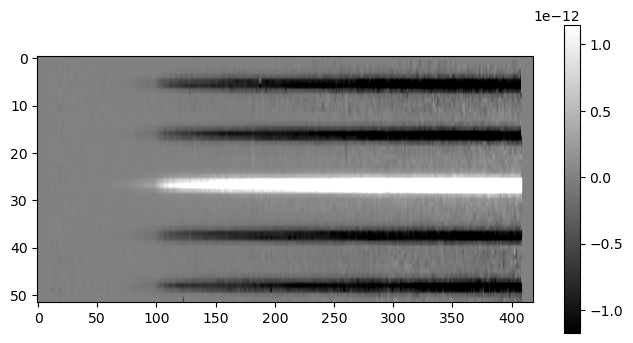

In [29]:
fig, axs = plt.subplots(nrows=1, figsize=(8,4))



sci_image = fits.open(final_2d_combine_name)['SCI'].data
### make in too like zscale in ds9 (can wipe out features so be careful)
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(sci_image)


cax = axs.imshow(sci_image, aspect=4, vmin=vmin, vmax=vmax, cmap='gray')

fig.colorbar(cax, ax=axs, orientation='vertical', label='') ## again find the units to the axis label



### Now look at the ERR and WHT arrays



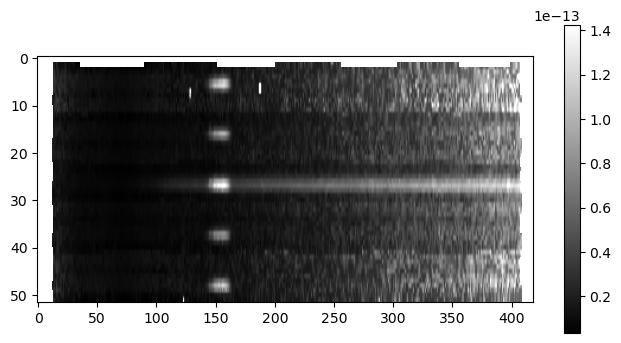

In [30]:
fig, axs = plt.subplots(nrows=1, figsize=(8,4))


final_2d_combine_name = 'jw02565-o007_s000020115_nirspec_clear-prism_s2d.fits'

sci_image = fits.open(final_2d_combine_name)['ERR'].data
### make in too like zscale in ds9 (can wipe out features so be careful)
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(sci_image)


cax = axs.imshow(sci_image, aspect=4, vmin=vmin, vmax=vmax, cmap='gray')

fig.colorbar(cax, ax=axs, orientation='vertical', label='') ## again find the units to the axis label



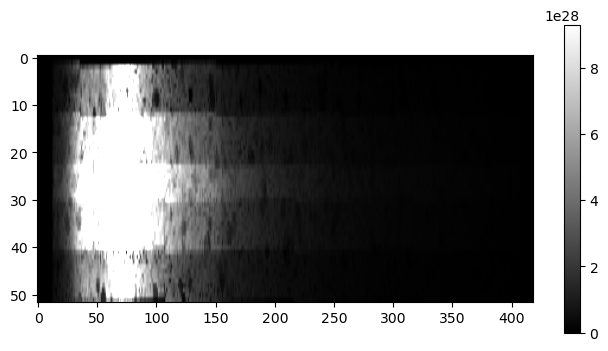

In [31]:
fig, axs = plt.subplots(nrows=1, figsize=(8,4))


final_2d_combine_name = 'jw02565-o007_s000020115_nirspec_clear-prism_s2d.fits'

sci_image = fits.open(final_2d_combine_name)['WHT'].data
### make in too like zscale in ds9 (can wipe out features so be careful)
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(sci_image)


cax = axs.imshow(sci_image, aspect=4, vmin=vmin, vmax=vmax, cmap='gray')

fig.colorbar(cax, ax=axs, orientation='vertical', label='') ## again find the units to the axis label

